In [1]:
# 双线性插值初始化内核权重
#FCN-32S
import numpy as np
def get_kernel_size(factor):
    return 2 * factor - factor % 2

def upsample_filt(size):
    """
        Make 2D bilinear kernel suitable for upsampling of the given(h,w) size. 
    """
    factor = (size + 1) // 2
    
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    
    return ( 1 - abs(og[0] - center) / factor) * \
           ( 1 - abs(og[1] - center) / factor) 
    

def bilinear_upsample_weights(factor, number_of_classes):
    """
        Create weights matrix for transposed convolution with bilinear filter initialization
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                       filter_size,
                       number_of_classes,
                       number_of_classes), dtype = np.float32)
    
    unsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        weights[:,:,i,i] = unsample_kernel
        
    return weights

In [2]:
%matplotlib inline
from __future__ import division

import os 
import sys
import tensorflow as tf

from matplotlib import pyplot as plt

slim = tf.contrib.slim
sys.path.append(os.path.expanduser("../slim/"))

from nets import vgg
from preprocessing import vgg_preprocessing

In [3]:
#GPU = 1
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 
checkpoints_dir = os.path.expanduser('/root/data/')
image_filename = '/root/data/object_1.jpg'
annotation_filename = '/root/data/segment_1.png'

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

In [4]:
tf.reset_default_graph()
image_filename_placehold = tf.placeholder(tf.string)
annotation_filename_placehold = tf.placeholder(tf.string)

is_training_placehold = tf.placeholder(tf.bool)

feed_dict_to_use = {
    image_filename_placehold:image_filename,
    annotation_filename_placehold:annotation_filename,
    is_training_placehold:True,
}

image_tensor = tf.read_file(image_filename_placehold)
annotation_tensor = tf.read_file(annotation_filename_placehold)

image_tensor = tf.image.decode_jpeg(image_tensor, channels = 3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels = 1)

# 单张图片  > 1,划分为前景类，  < 1,则为背景
class_labels_tensor = tf.greater_equal(annotation_tensor, 1) 
background_labels_tensor = tf.less(annotation_tensor, 1)

bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(axis = 2, values=[bit_mask_background, bit_mask_class,])

flat_labels = tf.reshape(tensor = combined_mask, shape=(-1,2))

In [5]:
#vgg 对3个通道RGB，分别计算均值，每个像素减去均值。
from preprocessing.vgg_preprocessing import (_mean_image_subtraction, _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 16 #vgg 缩小32倍，现在要放大回去
number_of_classes = 2 #单张图片，强行分为前景和背景2种类型

log_folder = os.path.expanduser("segment_log_folder")

vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')
image_float = tf.to_float(image_tensor, name = 'ToFloat')

original_shape = tf.shape(image_float)[0:2]

mean_centered_image = _mean_image_subtraction(image_float, [_R_MEAN, _G_MEAN, _B_MEAN])

target_input_size_factor = tf.ceil(
        tf.div(tf.to_float(original_shape),
              tf.to_float(upsample_factor)))

target_input_size = tf.to_int32(tf.multiply(target_input_size_factor, upsample_factor))

padding_size = (target_input_size - original_shape) // 2

mean_centered_image = tf.image.pad_to_bounding_box(mean_centered_image,
                                                  padding_size[0],
                                                  padding_size[1],
                                                  target_input_size[0],
                                                  target_input_size[1],)

processed_images = tf.expand_dims(mean_centered_image, 0)

upsample_filter_np = bilinear_upsample_weights(upsample_factor, number_of_classes)

upsample_filter_tensor = tf.Variable(upsample_filter_np, name = 'vgg_16/fc8/t_conv')

#slim.vgg16已经改为全卷积，不是全联接了，所以，可以传递SAME进去，改变成32分之1，否则224分之1
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, end_points = vgg.vgg_16_atrous(processed_images, 
                                    num_classes = 2,
                                    is_training = is_training_placehold,
                                    spatial_squeeze = False,
                                    fc_conv_padding = 'SAME'
                                   )

downsampled_logits_shape = tf.shape(logits)

upsampled_logits_shape = tf.stack([
        downsampled_logits_shape[0],
        original_shape[0],
        original_shape[1],
        downsampled_logits_shape[3],
    ])

print('logits=', logits.shape)
print('upsampled_logits_shape=', upsampled_logits_shape)

#反卷积，上采样，将feature map恢复原图大小
upsampled_logits = tf.nn.conv2d_transpose(logits,
                                         upsample_filter_tensor,#双线性插值核 32对应的是64
                                         output_shape = upsampled_logits_shape,#希望得到的精确大小
                                         strides = [1, upsample_factor, upsample_factor, 1], #扩大32倍
                                         padding = 'SAME')
print('upsampled_logits=', upsampled_logits.shape)

#新的logits展平
flat_logits = tf.reshape(tensor = upsampled_logits, shape = (-1, number_of_classes))


cross_entropies = tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits, labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

#每个像素对应的最大概率的类别
pred = tf.argmax(upsampled_logits, axis=3)

#扩大后的logits的每个像素的概率的具体值
probabilities = tf.nn.softmax(upsampled_logits)


with tf.variable_scope("adam_vars"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    
    #计算梯度
    gradients = optimizer.compute_gradients(loss = cross_entropy_sum)
    
    for grad_var_pair in gradients:
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        gradient_name_to_save = current_variable.name.replace(":","_")
        
        #输入summary，方便可视化观察
        tf.summary.histogram(gradient_name_to_save, current_gradient)
        
    #更新梯度
    train_step = optimizer.apply_gradients(grads_and_vars = gradients)

#获取vgg变量的定义 获取在imagenet上训练的vgg的各个变量的权重。去掉改变的变量
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])#原来是4096*1000，现在只有2个分类，不同

#需要初始化，将获取的值先保存到列表里面
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])
adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

tf.summary.scalar('cross_entropy_loss', cross_entropy_sum)
merged_summary_op = tf.summary.merge_all()

summary_string_writer = tf.summary.FileWriter(log_folder)

if not os.path.exists(log_folder):
    os.makedirs(log_folder)


read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
    vgg_checkpoint_path,
    vgg_except_fc8_weights,
)

vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)



logits= (1, ?, ?, 2)
upsampled_logits_shape= Tensor("stack:0", shape=(4,), dtype=int32)
upsampled_logits= (?, ?, ?, ?)


INFO:tensorflow:Restoring parameters from /root/data/vgg_16.ckpt


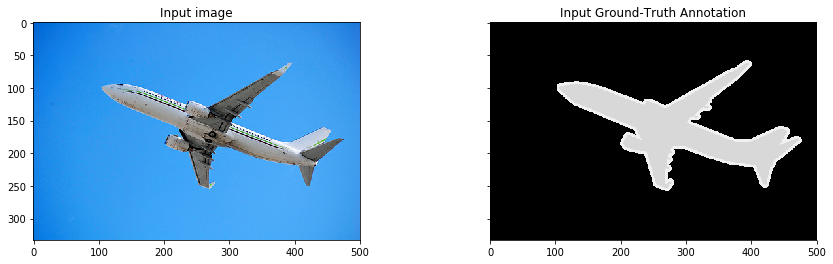

(4,)


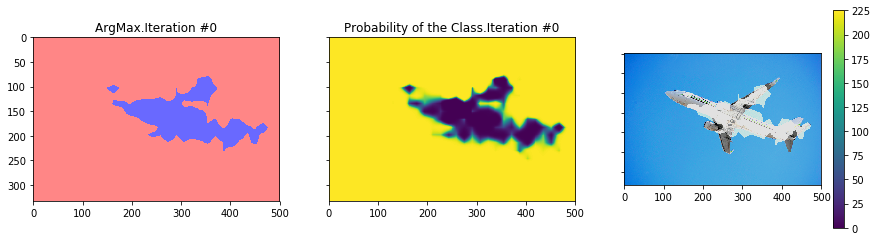

Curent loss:174427.4


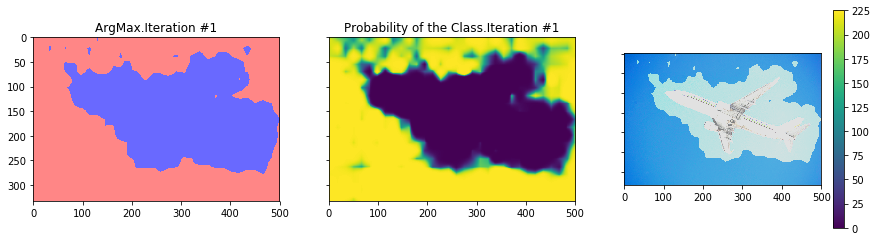

Curent loss:55694.54


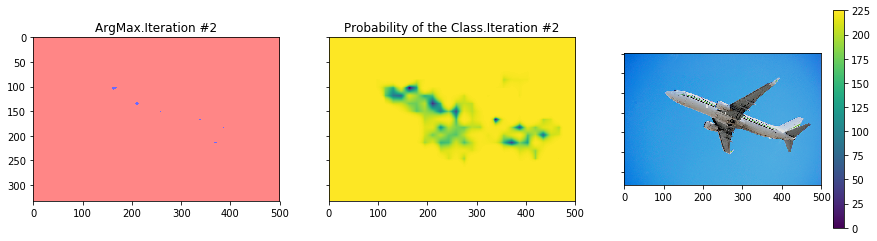

Curent loss:361393.06


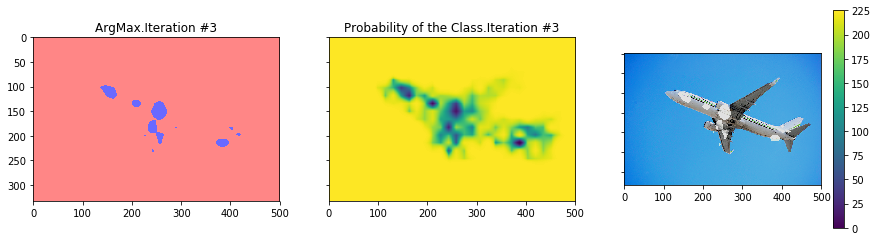

Curent loss:88965.87


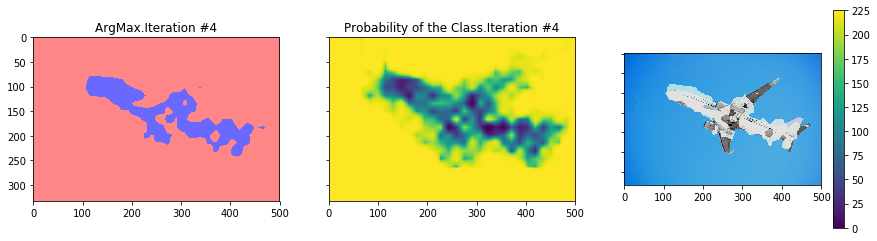

Curent loss:49752.58


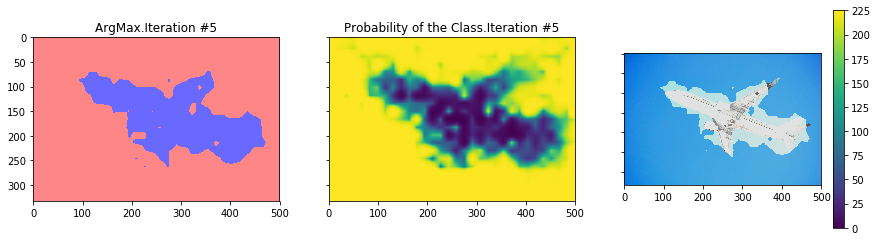

Curent loss:23419.36


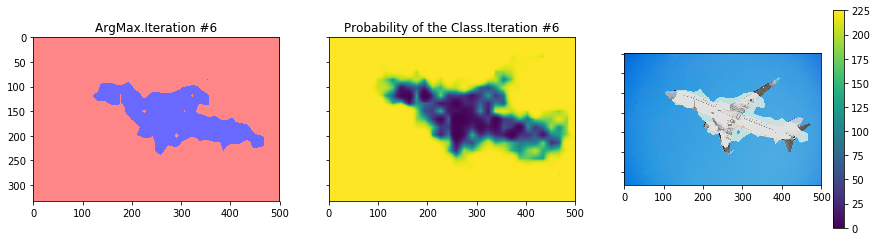

Curent loss:28141.89


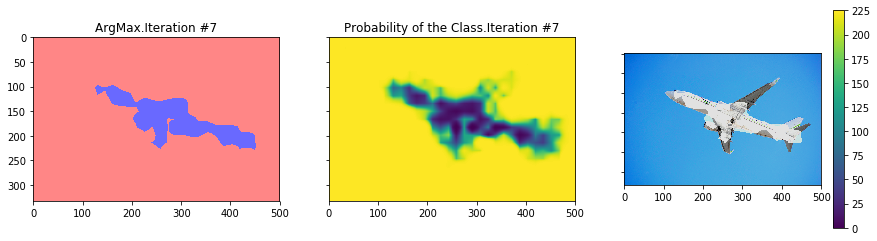

Curent loss:20662.916


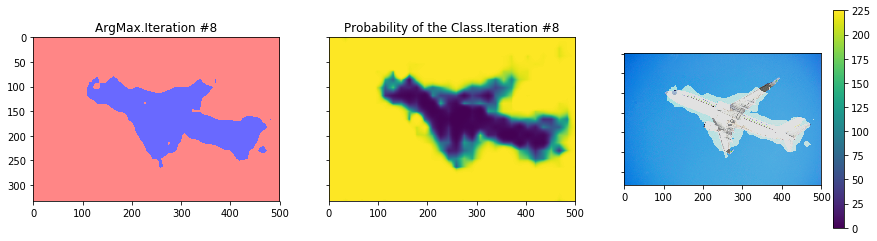

Curent loss:26271.105


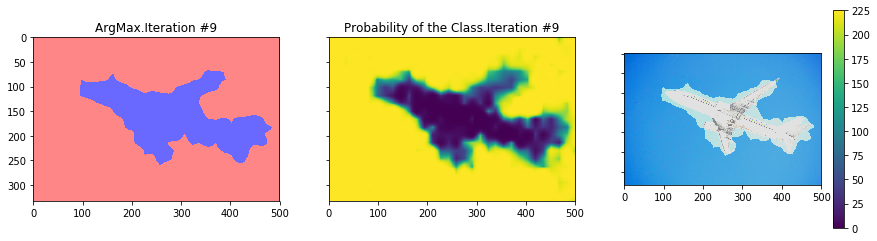

Curent loss:16415.889


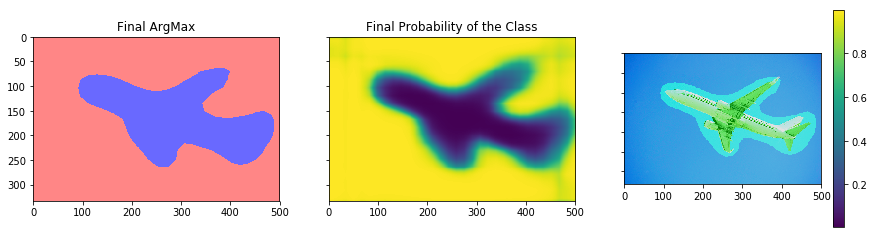

Final loss:34275.0


In [6]:
init_op = tf.global_variables_initializer()
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(config = sess_config)

with sess:
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    read_vgg_weights_except_fc8_func(sess)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor,],
                                            feed_dict = feed_dict_to_use)
    
    f, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.imshow(train_image)
    ax1.set_title('Input image')

    probability_graph = ax2.imshow(np.dstack((train_annotation, )*3)*100)
    ax2.set_title("Input Ground-Truth Annotation")
    
    plt.show()
    
    downsampled_logits_value, train_annotation = sess.run([downsampled_logits_shape, annotation_tensor,],
                                            feed_dict = feed_dict_to_use)
    print(downsampled_logits_shape.shape)
    

    for i in range(10):
        loss, summary_string = sess.run([cross_entropy_sum, merged_summary_op], 
                                        feed_dict = feed_dict_to_use) #计算交叉墒

        sess.run(train_step, feed_dict = feed_dict_to_use) #更新梯度

        pred_np, probabilities_np = sess.run([pred, probabilities], #每个像素是前景的概率是多少
                                        feed_dict = feed_dict_to_use)#每个像素的最大可能的分类

        summary_string_writer.add_summary(summary_string, i)

        cmap = plt.get_cmap('bwr')

        f, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1),vmax=1.5, vmin=-0.4,cmap=cmap)
        ax1.set_title('ArgMax.Iteration #'+str(i))

        probability_graph = ax2.imshow(probabilities_np.squeeze()[:,:,0])
        ax2.set_title("Probability of the Class.Iteration #"+str(i))

        mask = np.multiply(np.uint32(pred_np.squeeze()),128)
        mask = np.stack([mask,]*3, axis=-1)

        masked_image = np.uint8(np.clip(train_image+mask, 0, 225))
        probability_graph = ax3.imshow(masked_image)

        plt.colorbar(probability_graph)
        plt.show()
        
        print("Curent loss:" + str(loss))
        
    
    feed_dict_to_use[is_training_placehold] = False
    
    final_prediction, final_probabilities, final_loss = sess.run([pred, probabilities, 
                                        cross_entropy_sum], #每个像素是前景的概率是多少
                                        feed_dict = feed_dict_to_use)#每个像素的最大可能的分类
    
    
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
    ax1.imshow(np.uint8(final_prediction.squeeze() != 1),vmax=1.5, vmin=-0.4,cmap=cmap)
    ax1.set_title('Final ArgMax')

    probability_graph = ax2.imshow(final_probabilities.squeeze()[:,:,0])
    ax2.set_title("Final Probability of the Class")
    plt.colorbar(probability_graph)

    mask = np.multiply(np.uint32(final_prediction.squeeze()), 128)
    mask = np.stack([np.zeros(mask.shape),
                    mask,
                    np.zeros(mask.shape)]
                    , axis=-1)

    masked_image = np.uint8(np.clip(train_image+mask, 0, 225))
    probability_graph = ax3.imshow(masked_image)

    plt.show()

    print("Final loss:" + str(final_loss))
        
summary_string_writer.close()

In [7]:
#进行CRF处理
#安装方法： 
# apt-get update
# apt install git
# pip install -U cython
# pip3 install git+https://github.com/lucasb-eyer/pydensecrf.git

(2, 166500)


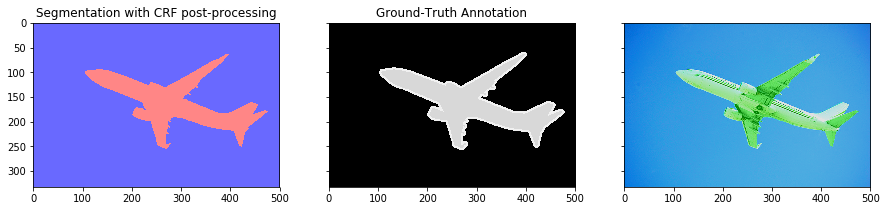

IoU:83.15%


In [8]:
import sys

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, \
    create_pairwise_bilateral,create_pairwise_gaussian,softmax_to_unary

image = train_image

#置信度的图sqeeze
processed_probabilities = final_probabilities.squeeze()

#softmax输出的onehot的depth维度调整到前面 符合crf的格式要求
softmax = processed_probabilities.transpose((2, 0, 1))

#向量化
unary = softmax_to_unary(softmax)
print(unary.shape)

#改成C连续的数组
unary = np.ascontiguousarray(unary)

#计算图片的密集场，输入图片的长宽，通道数
d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

#得到一元能量函数 softmax的结果作为该函数的输入
d.setUnaryEnergy(unary)

#用高斯近似的方法计算二元色函数
#全联接的方式是计算每2个像素之间的关系
feats = create_pairwise_gaussian(sdims=(10,10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                   kernel=dcrf.DIAG_KERNEL,
                   normalization=dcrf.NORMALIZE_SYMMETRIC)

#use local color to refine
feats = create_pairwise_bilateral(sdims=(50,50), schan=(20,20,20),
                                 img = image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                   kernel=dcrf.DIAG_KERNEL,
                   normalization=dcrf.NORMALIZE_SYMMETRIC)


Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))
cmap = plt.get_cmap('bwr')

#画图
f, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')

probability_graph = ax2.imshow(np.dstack((train_annotation, )*3)*100)
ax2.set_title("Ground-Truth Annotation")
# plt.colorbar(probability_graph)

mask = np.multiply(np.uint32(res.squeeze()), 128)
mask = np.stack([np.zeros(mask.shape),
                mask,
                np.zeros(mask.shape)]
                , axis=-1)

masked_image = np.uint8(np.clip(np.uint32(train_image) + mask, 0, 225))
probability_graph = ax3.imshow(masked_image)

plt.show()

intersection = np.logical_and(res, train_annotation.squeeze())
union = np.logical_or(res, train_annotation.squeeze())

sum_intersection = np.sum(intersection)
sum_union = np.sum(union)

print("IoU:%.2f%%"%((sum_intersection/sum_union) * 100))